# Prosper Loan Data — Part II: Exploratory Data Analysis
## by Luca Scarpantonio

## Investigation Overview
This presentation explores the Prosper Loan dataset to uncover key drivers of loan interest rates,
loan performance, and borrower characteristics.

**Key Insights:**
- BorrowerAPR distribution is right-skewed, with most loans between 10% and 30% APR.
- Higher ProsperScores correlate strongly with lower APRs, confirming risk-based pricing.
- Borrower socio-economic factors (income range & employment status) affect interest rates.
- Completed loans dominate the dataset; defaulted loans show higher APRs.

## Dataset Overview
The dataset contains over 100k loans from Prosper Marketplace (2009 onwards).
Key variables used:
- **BorrowerAPR** (interest rate)
- **ProsperScore** (credit risk score, 1–11)
- **EmploymentStatus & IncomeRange** (socioeconomic factors)
- **LoanStatus** (completed, current, defaulted, charged-off)

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe

loans = pd.read_csv('data/prosperLoanData.csv')

# refer to Part I in the project instructions for data cleaning steps
mask_employed_zero_income = (loans['EmploymentStatus'] == 'Employed') & (loans['IncomeRange'] == '$0')
mask_unemployed_positive_income = (loans['EmploymentStatus'] == 'Not employed') & (loans['IncomeRange'] != '$0')
mask_zero_apr = loans['BorrowerAPR'] == 0
loans_clean = loans[~(mask_employed_zero_income | mask_unemployed_positive_income | mask_zero_apr)].copy()
loans_clean.reset_index(drop=True, inplace=True)

mask_not_disp = loans_clean['IncomeRange'].astype('string').str.strip().str.lower().eq('not displayed')
mask_nan_inc  = loans_clean['IncomeRange'].isna()

loans_ir_clean = loans_clean.loc[~(mask_not_disp | mask_nan_inc)].copy()
loans_ir_clean["year"] = pd.to_datetime(loans_ir_clean["ListingCreationDate"], format='mixed').dt.year
input_df = loans_ir_clean


ps_numeric = pd.to_numeric(input_df['ProsperScore'], errors='coerce')
removed_ps = ps_numeric.isna().sum()

loans_clean = input_df.loc[ps_numeric.notna()].copy()
loans_clean['ProsperScore'] = ps_numeric.loc[ps_numeric.notna()].astype(float)
loans_clean.reset_index(drop=True, inplace=True)

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

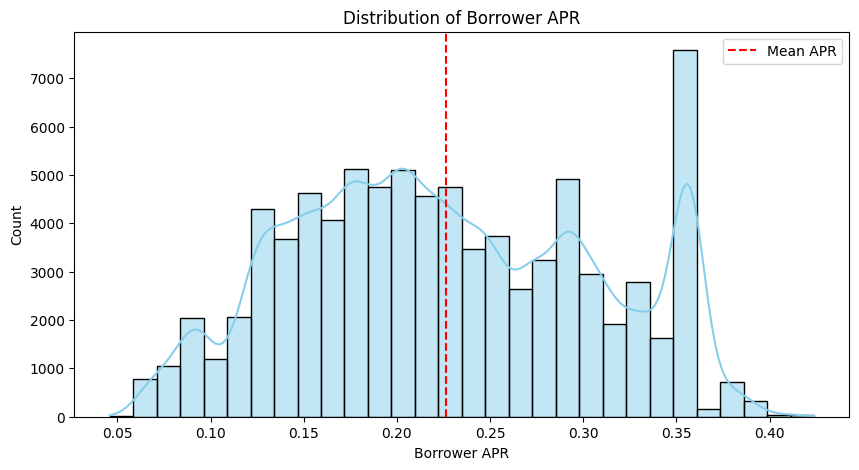

In [3]:
plt.figure(figsize=(10, 5))
sns.histplot(loans_clean['BorrowerAPR'], bins=30, kde=True, color='skyblue')
plt.axvline(loans_clean['BorrowerAPR'].mean(), color='red', linestyle='--', label='Mean APR')
plt.title('Distribution of Borrower APR')
plt.xlabel('Borrower APR')
plt.ylabel('Count')
plt.legend()
plt.show()

### Data wrangling steps included:
- Excluding pre-2009 loans to ensure `ProsperScore` completeness
- Removing rows with missing key fields (APR, Loan Amount, Loan Status)
- Dropping `"Not displayed"` income range to reduce noise

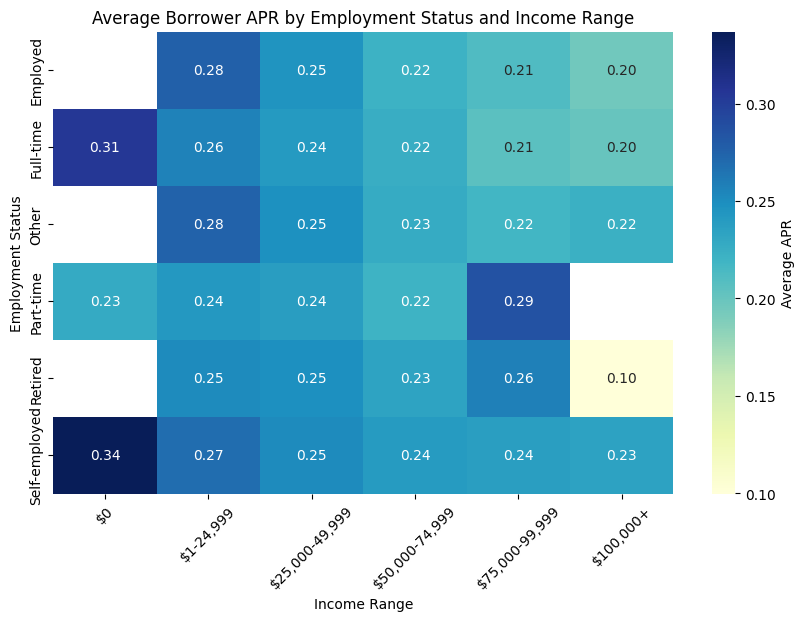

In [4]:
income_order = [
    '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999',
    '$75,000-99,999', '$100,000+'
]

pivot_table_apr = loans_clean.pivot_table(
   values='BorrowerAPR',
   index='EmploymentStatus',
   columns='IncomeRange',
   aggfunc='mean'
)
pivot_table_apr = pivot_table_apr[income_order]
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_apr, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average APR'})
plt.title('Average Borrower APR by Employment Status and Income Range')
plt.xlabel('Income Range')
plt.ylabel('Employment Status')
plt.xticks(rotation=45)
plt.show()

## Visualization 1 — BorrowerAPR Distribution

This plot shows the distribution of BorrowerAPR (interest rate) across all loans.

- **Shape:** The distribution is right-skewed, with most loans between **10% and 30%** APR.  
- **Mean APR:** Dashed line at ~21% highlights the central tendency.

**Observation:**  
The wide spread indicates significant variation in borrower risk.  
This motivates examining factors (like ProsperScore) that explain this variability.

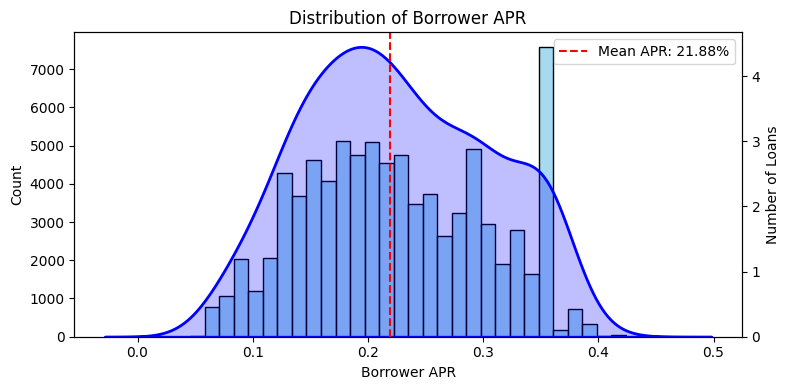

In [5]:
fig, ax1 = plt.subplots(figsize=(8,4))

# Istogramma sui conteggi (asse sinistro)
sns.histplot(loans_clean['BorrowerAPR'], bins=30, color='skyblue', edgecolor='black', ax=ax1)
ax1.set_ylabel("Count")
ax1.set_xlabel("Borrower APR")

# Secondo asse per la densità
ax2 = ax1.twinx()
sns.kdeplot(loans_clean['BorrowerAPR'], bw_adjust=3, color='blue', fill='blue', ax=ax2, lw=2)
ax2.set_ylabel("Density")
ax2.grid(False)  # per non duplicare la griglia

# Add mean line
mean_apr = loans['BorrowerAPR'].mean()
plt.axvline(mean_apr, color='red', linestyle='--', linewidth=1.5, label=f"Mean APR: {mean_apr:.2%}")

# Titles and labels
plt.title("Distribution of Borrower APR")
plt.xlabel("Borrower APR")
plt.ylabel("Number of Loans")
plt.legend()
plt.tight_layout()
plt.show()

## Visualization 2 — BorrowerAPR by ProsperScore

This violin plot shows how APR changes across ProsperScore levels (1–10).

- **Clear negative trend:** Higher ProsperScore (lower credit risk) → lower median APR.  
- **Spread:** High-risk borrowers (score 1–3) have more variability in APRs.

**Observation:**  
This confirms Prosper's **risk-based pricing model**: safer borrowers receive cheaper loans.

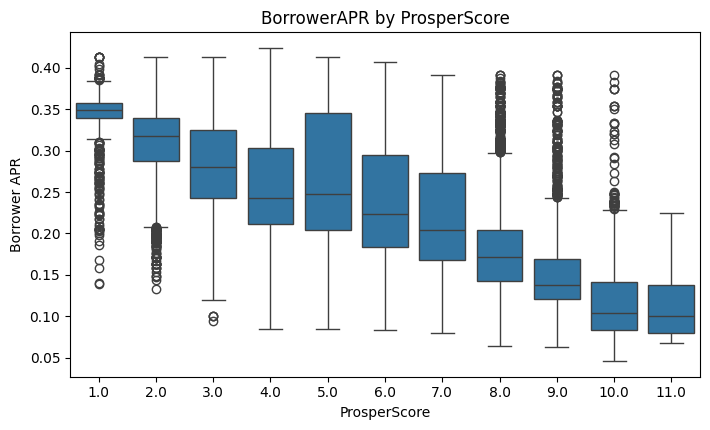

In [6]:
plt.figure(figsize=(7.2, 4.4))
sns.boxplot(
    data=loans_clean, x='ProsperScore', y='BorrowerAPR'
)
plt.title("BorrowerAPR by ProsperScore")
plt.xlabel("ProsperScore")
plt.ylabel("Borrower APR")
plt.tight_layout()
plt.show()

## Visualization 3 — Loan Status by Term

This countplot shows the distribution of loan statuses, split by loan term (36 vs 60 months).

- **Most loans:** Completed or Current.  
- **Risk signal:** 60-month loans have a slightly higher proportion of **Chargedoff** and **Past Due**.

**Observation:**  
Loan term is not just a maturity choice — it is associated with both **larger loan amounts** and **slightly higher risk**, which must be considered in pricing.


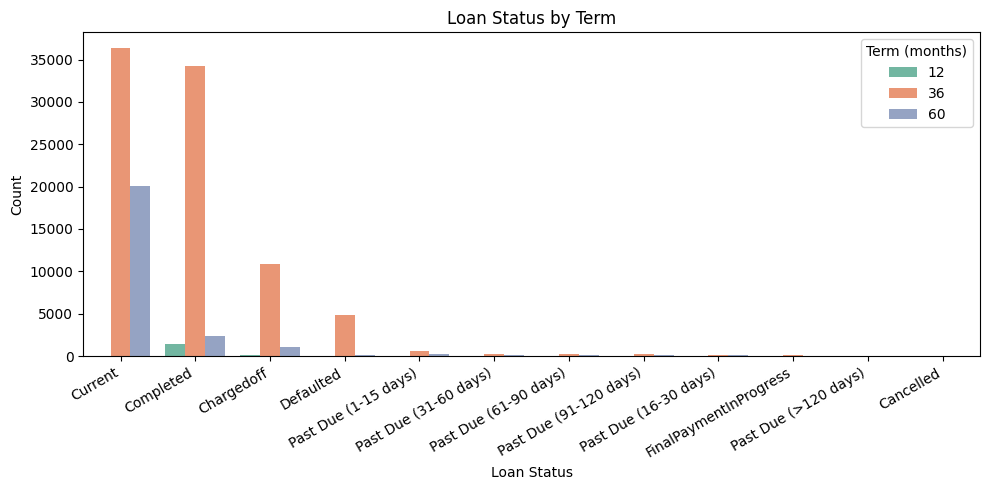

In [7]:
plt.figure(figsize=(10, 5))
order_ls = loans['LoanStatus'].value_counts().index
sns.countplot(
    data=loans, x='LoanStatus', hue='Term',
    order=order_ls, palette='Set2'
)
plt.xticks(rotation=30, ha='right')
plt.title("Loan Status by Term")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.legend(title="Term (months)")
plt.tight_layout()
plt.show()

>**Generate Slideshow**: Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show. . From the terminal or command line, use the following expression.

## Visualization 4 — Loan Status by Employment Status

This plot explores the distribution of loan statuses across different employment types,
highlighting how borrower reliability varies by employment condition.

**Observations:**
- **Full-time borrowers** represent the majority of loans and have a healthy proportion of completed loans.
- **Part-time borrowers** have the highest share of defaulted or charged-off loans,
  suggesting they are the least reliable group in terms of loan repayment.
- **Unemployed borrowers** also show an elevated default rate, though they represent a smaller fraction of the dataset.
- This confirms that **employment stability is a key predictor of loan performance**.

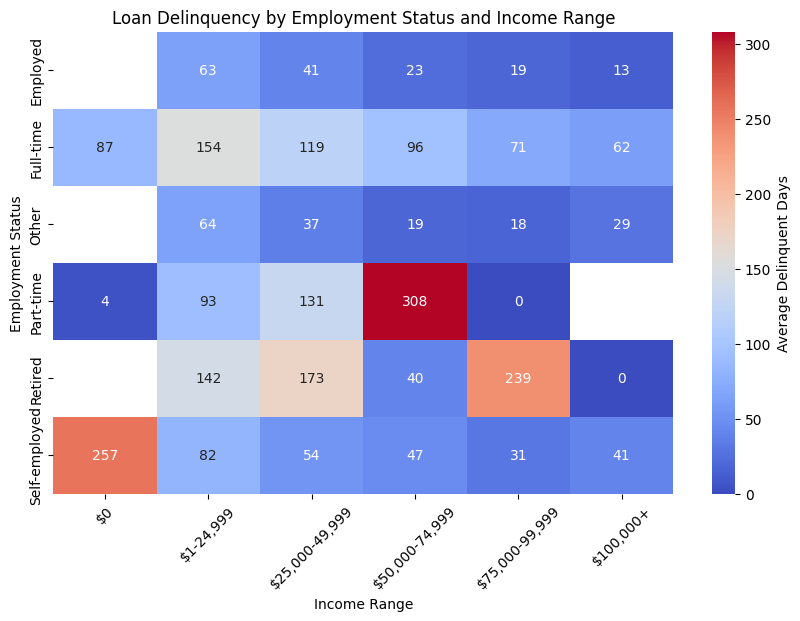

In [8]:
pivot_table = loans_clean.pivot_table(
    values='LoanCurrentDaysDelinquent',
    index='EmploymentStatus',
    columns='IncomeRange',
    aggfunc='mean'
)

income_order = ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999',
                '$75,000-99,999', '$100,000+']

pivot_table = pivot_table[income_order]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="coolwarm", cbar_kws={'label': 'Average Delinquent Days'})
plt.title('Loan Delinquency by Employment Status and Income Range')
plt.xlabel('Income Range')
plt.ylabel('Employment Status')
plt.xticks(rotation=45)
plt.show()

In [9]:
!jupyter nbconvert Part_II_slide.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Part_II_slide.ipynb to slides
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 624594 bytes to Part_II_slide.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Part_II_slide.slides.html
Use Control-C to stop this server
^C


> This should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation! At last, you can stop the Kernel. 